# 360-degree 3D Object Detection

In [1]:
import argparse
import mmcv
import os
import torch
import warnings
import tempfile
import torch.distributed as dist
import shutil
import numpy as np
import matplotlib.pyplot as plt

from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmdet3d.apis import single_gpu_test
from mmdet3d.datasets import build_dataset
from projects.mmdet3d_plugin.datasets.builder import build_dataloader
from mmdet3d.models import build_model
from mmdet.apis import set_random_seed
from projects.mmdet3d_plugin.bevformer.apis.test import custom_multi_gpu_test
from mmdet.datasets import replace_ImageToTensor
from mmdet3d.datasets.pipelines import Compose
from mmdet3d.core.bbox import get_box_type

import time
import os.path as osp
from copy import deepcopy

In [3]:
rank, world_size = get_dist_info()

os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '29503'

# initialize the process group
dist.init_process_group("gloo", rank=rank, world_size=world_size)

[W socket.cpp:401] [c10d] The server socket has failed to bind to [::]:29503 (errno: 98 - Address already in use).
[W socket.cpp:401] [c10d] The server socket has failed to bind to ?UNKNOWN? (errno: 98 - Address already in use).
[E socket.cpp:435] [c10d] The server socket has failed to listen on any local network address.


RuntimeError: The server socket has failed to listen on any local network address. The server socket has failed to bind to [::]:29503 (errno: 98 - Address already in use). The server socket has failed to bind to ?UNKNOWN? (errno: 98 - Address already in use).

In [5]:
config = './projects/configs/bevformer/bevformer_base.py'
ckpt = '../BEVFormer/ckpts/bevformer_r101_dcn_24ep.pth'

device = 'cuda:7'

# os.environ["RANK"] = "7"

cfg = Config.fromfile(config)

# import modules from string list.
if cfg.get('custom_imports', None):
    print("custom import")
    from mmcv.utils import import_modules_from_strings
    import_modules_from_strings(**cfg['custom_imports'])

# import modules from plguin/xx, registry will be updated
if hasattr(cfg, 'plugin'):
    print("plugin import")
    if cfg.plugin:
        import importlib
        if hasattr(cfg, 'plugin_dir'):
            plugin_dir = cfg.plugin_dir
            _module_dir = os.path.dirname(plugin_dir)
            _module_dir = _module_dir.split('/')
            _module_path = _module_dir[0]

            for m in _module_dir[1:]:
                _module_path = _module_path + '.' + m
            print(_module_path)
            plg_lib = importlib.import_module(_module_path)
        else:
            # import dir is the dirpath for the config file
            _module_dir = os.path.dirname(args.config)
            _module_dir = _module_dir.split('/')
            _module_path = _module_dir[0]
            for m in _module_dir[1:]:
                _module_path = _module_path + '.' + m
            print(_module_path)
            plg_lib = importlib.import_module(_module_path)

# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

cfg.model.pretrained = None

# in case the test dataset is concatenated
samples_per_gpu = 1
if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
    samples_per_gpu = cfg.data.test.pop('samples_per_gpu', 1)
    if samples_per_gpu > 1:
        # Replace 'ImageToTensor' to 'DefaultFormatBundle'
        cfg.data.test.pipeline = replace_ImageToTensor(
            cfg.data.test.pipeline)
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
    samples_per_gpu = max(
        [ds_cfg.pop('samples_per_gpu', 1) for ds_cfg in cfg.data.test])
    if samples_per_gpu > 1:
        for ds_cfg in cfg.data.test:
            ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

# init distributed env first, since logger depends on the dist info.
# distributed = True
# init_dist('pytorch', **cfg.dist_params)

# build the dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=samples_per_gpu,
    workers_per_gpu=cfg.data.workers_per_gpu,
    # dist=False,
    dist=True,
    shuffle=False,
    nonshuffler_sampler=cfg.data.nonshuffler_sampler,
)

# build the model and load checkpoint
cfg.model.train_cfg = None
model = build_model(cfg.model, test_cfg=cfg.get('test_cfg'))

fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)

checkpoint = load_checkpoint(model, ckpt, map_location='cpu')

# old versions did not save class info in checkpoints, this walkaround is
# for backward compatibility
if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES
# palette for visualization in segmentation tasks
if 'PALETTE' in checkpoint.get('meta', {}):
    model.PALETTE = checkpoint['meta']['PALETTE']
elif hasattr(dataset, 'PALETTE'):
    # segmentation dataset has `PALETTE` attribute
    model.PALETTE = dataset.PALETTE

# Built model to single CUDA device
if device is not 'cpu':
    torch.cuda.set_device(device)
model.to(device)
model.eval()

<>:105: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:105: SyntaxWarning: "is not" with a literal. Did you mean "!="?


plugin import
projects.mmdet3d_plugin
load checkpoint from local path: ../BEVFormer/ckpts/bevformer_r101_dcn_24ep.pth


2022-10-10 21:27:45,160 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.0.conv2 is upgraded to version 2.
2022-10-10 21:27:45,164 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.1.conv2 is upgraded to version 2.
2022-10-10 21:27:45,168 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.2.conv2 is upgraded to version 2.
2022-10-10 21:27:45,171 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.3.conv2 is upgraded to version 2.
2022-10-10 21:27:45,175 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.4.conv2 is upgraded to version 2.
2022-10-10 21:27:45,179 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.5.conv2 is upgraded to version 2.
2022-10-10 21:27:45,183 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.6.conv2 is upgraded to version 2.
2022-10-10 21:27:45,186 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.7.conv2 is upgraded to version 2.
2022-10-10 21:27:45,189 - root - INFO - ModulatedDeformC

BEVFormer(
  (pts_bbox_head): BEVFormerHead(
    (loss_cls): FocalLoss()
    (loss_bbox): L1Loss()
    (loss_iou): GIoULoss()
    (activate): ReLU(inplace=True)
    (positional_encoding): LearnedPositionalEncoding(num_feats=128, row_num_embed=200, col_num_embed=200)
    (transformer): PerceptionTransformer(
      (encoder): BEVFormerEncoder(
        (layers): ModuleList(
          (0): BEVFormerLayer(
            (attentions): ModuleList(
              (0): TemporalSelfAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (sampling_offsets): Linear(in_features=512, out_features=128, bias=True)
                (attention_weights): Linear(in_features=512, out_features=64, bias=True)
                (value_proj): Linear(in_features=256, out_features=256, bias=True)
                (output_proj): Linear(in_features=256, out_features=256, bias=True)
              )
              (1): SpatialCrossAttention(
                (dropout): Dropout(p=0.1, inplace=False

In [4]:
# Ready to inference!
bbox_results = []
mask_results = []
dataset = data_loader.dataset
rank, world_size = get_dist_info()
if rank == 0:
    prog_bar = mmcv.ProgressBar(len(dataset))
time.sleep(2)  # This line can prevent deadlock problem in some cases.
have_mask = False

# Model Run
for i, data in enumerate(data_loader):
    with torch.no_grad():
        
        # JEHO: Move image Tensor to CUDA device
        data['img_metas'] = data['img_metas'][0].data
        data['img'] = data['img'][0].data
        data['img'][0] = data['img'][0].to(device)
        
        result = model(return_loss=False, rescale=True, **data)
        # encode mask results
        if isinstance(result, dict):
            if 'bbox_results' in result.keys():
                bbox_result = result['bbox_results']
                batch_size = len(result['bbox_results'])
                bbox_results.extend(bbox_result)
            if 'mask_results' in result.keys() and result['mask_results'] is not None:
                mask_result = custom_encode_mask_results(result['mask_results'])
                mask_results.extend(mask_result)
                have_mask = True
                print("have mask")
        else:
            batch_size = len(result)
            bbox_results.extend(result)
    
    if rank == 0:
        for _ in range(batch_size * world_size):
            prog_bar.update()
    
    # 일단 10개만 @@@@@@@@@@@@@@@@@@@@@@@@@@@
    # if i == 100:
    #     break
        
# Collect results
MAX_LEN = 512
size = len(dataset)

# 32 is whitespace
dir_tensor = torch.full((MAX_LEN, ), 32, dtype=torch.uint8, device=device)
if rank == 0:
    mmcv.mkdir_or_exist('.dist_test')
    tmpdir = tempfile.mkdtemp(dir='.dist_test')
    tmpdir = torch.tensor(
        bytearray(tmpdir.encode()), dtype=torch.uint8, device=device)
    dir_tensor[:len(tmpdir)] = tmpdir

dist.broadcast(dir_tensor, 0)
tmpdir = dir_tensor.cpu().numpy().tobytes().decode().rstrip()

# dump the part result to the dir
mmcv.dump(bbox_results, osp.join(tmpdir, f'part_{rank}.pkl'))
dist.barrier()

new_bbox_results = []

# collect all parts
if rank == 0:
    # load results of all parts from tmp dir
    part_list = []
    for i in range(world_size):
        part_file = osp.join(tmpdir, f'part_{i}.pkl')
        part_list.append(mmcv.load(part_file))

    # sort the results
    '''
    bacause we change the sample of the evaluation stage to make sure that each gpu will handle continuous sample,
    '''
    #for res in zip(*part_list):
    for res in part_list:  
        new_bbox_results.extend(list(res))
    # the dataloader may pad some samples
    new_bbox_results = new_bbox_results[:size]
    # remove tmp dir
    shutil.rmtree(tmpdir)

# return
outputs = {'bbox_results': new_bbox_results, 'mask_results': None}

[                              ] 1/6019, 0.0 task/s, elapsed: 20s, ETA: 123252s

/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/bevformer/modules/transformer.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  shift = bev_queries.new_tensor(
/data/home/jeholee/anaconda3/envs/omnicv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/core/bbox/coders/nms_free_coder.py:57: UserWarning: __floordiv__ is deprecated, and its behavior 

[                               ] 2/6019, 0.1 task/s, elapsed: 21s, ETA: 63084s

/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/core/bbox/coders/nms_free_coder.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 6019/6019, 1.7 task/s, elapsed: 3533s, ETA:     0s

In [24]:
len(outputs['bbox_results'])

6019

In [7]:
outputs_copy = deepcopy(outputs)

In [10]:
outputs_copy_2 = deepcopy(outputs)

In [11]:
# Write Results into File
mmcv.dump(outputs['bbox_results'], './output.pkl')

kwargs = {}
kwargs['jsonfile_prefix'] = osp.join('test', config.split(
    '/')[-1].split('.')[-2], time.ctime().replace(' ', '_').replace(':', '_'))

In [14]:
kwargs

{'jsonfile_prefix': 'test/bevformer_base/Thu_Oct__6_10_30_45_2022'}

In [ ]:
# Just store the results
dataset.format_results(outputs['bbox_results'], **kwargs)

In [23]:
# Eval
eval_kwargs = cfg.get('evaluation', {}).copy()
# hard-code way to remove EvalHook args
for key in ['interval', 'tmpdir', 'start', 'gpu_collect', 'save_best', 'rule']:
    eval_kwargs.pop(key, None)
eval_kwargs.update(dict(metric="bbox", **kwargs))

print(dataset.evaluate(outputs['bbox_results'], **eval_kwargs))


Formating bboxes of pts_bbox
Start to convert detection format...
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 6019/6019, 15.2 task/s, elapsed: 396s, ETA:     0s
Results writes to test/bevformer_base/Thu_Oct__6_10_30_45_2022/pts_bbox/results_nusc.json
Evaluating bboxes of pts_bbox
Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 53.131 seconds.
Reverse indexing ...
Done reverse indexing in 17.6 seconds.
Initializing nuScenes detection evaluation
Loaded results from test/bevformer_base/Thu_Oct__6_10_30_45_2022/pts_bbox/results_nusc.json. Found detections for 6019 samples.
Loading annotations for val split from nuScenes version: v1.0-trainval


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 6019/6019 [00:13<00:00, 433.61it/s]


Loaded ground truth annotations for 6019 samples.
Filtering predictions
=> Original number of boxes: 1337450
=> After distance based filtering: 1337075
=> After LIDAR and RADAR points based filtering: 1337075
=> After bike rack filtering: 1336523
Filtering ground truth annotations
=> Original number of boxes: 187528
=> After distance based filtering: 134565
=> After LIDAR and RADAR points based filtering: 121871
=> After bike rack filtering: 121861
Accumulating metric data...
Calculating metrics...
Saving metrics to: test/bevformer_base/Thu_Oct__6_10_30_45_2022/pts_bbox
mAP: 0.4167
mATE: 0.6728
mASE: 0.7089
mAOE: 1.5624
mAVE: 0.3933
mAAE: 0.1974
NDS: 0.4111
Eval time: 241.3s

Per-class results:
Object Class	AP	ATE	ASE	AOE	AVE	AAE
car	0.617	0.463	0.749	1.593	0.324	0.196
truck	0.370	0.726	0.791	1.599	0.340	0.194
bus	0.445	0.746	0.858	1.567	0.861	0.272
trailer	0.171	0.971	0.840	1.643	0.338	0.078
construction_vehicle	0.129	0.998	0.688	1.570	0.131	0.374
pedestrian	0.494	0.642	0.337	1.563	0.

# Visualize the inference results!

In [4]:
import mmcv
from nuscenes.nuscenes import NuScenes
from PIL import Image
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from typing import Tuple, List, Iterable
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib import rcParams
from matplotlib.axes import Axes
from pyquaternion import Quaternion
from PIL import Image
from matplotlib import rcParams
from matplotlib.axes import Axes
from pyquaternion import Quaternion
from tqdm import tqdm
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.eval.common.data_classes import EvalBoxes, EvalBox
from nuscenes.eval.detection.data_classes import DetectionBox
from nuscenes.eval.detection.utils import category_to_detection_name
from nuscenes.eval.detection.render import visualize_sample

In [3]:
cams = ['CAM_FRONT',
 'CAM_FRONT_RIGHT',
 'CAM_BACK_RIGHT',
 'CAM_BACK',
 'CAM_BACK_LEFT',
 'CAM_FRONT_LEFT']

In [5]:
def render_annotation(
        anntoken: str,
        margin: float = 10,
        view: np.ndarray = np.eye(4),
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        out_path: str = 'render.png',
        extra_info: bool = False) -> None:
    """
    Render selected annotation.
    :param anntoken: Sample_annotation token.
    :param margin: How many meters in each direction to include in LIDAR view.
    :param view: LIDAR view point.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param out_path: Optional path to save the rendered figure to disk.
    :param extra_info: Whether to render extra information below camera view.
    """
    ann_record = nusc.get('sample_annotation', anntoken)
    sample_record = nusc.get('sample', ann_record['sample_token'])
    assert 'LIDAR_TOP' in sample_record['data'].keys(), 'Error: No LIDAR_TOP in data, unable to render.'

    # Figure out which camera the object is fully visible in (this may return nothing).
    boxes, cam = [], []
    cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
    all_bboxes = []
    select_cams = []
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=box_vis_level,
                                           selected_anntokens=[anntoken])
        if len(boxes) > 0:
            all_bboxes.append(boxes)
            select_cams.append(cam)
            # We found an image that matches. Let's abort.
    # assert len(boxes) > 0, 'Error: Could not find image where annotation is visible. ' \
    #                      'Try using e.g. BoxVisibility.ANY.'
    # assert len(boxes) < 2, 'Error: Found multiple annotations. Something is wrong!'

    num_cam = len(all_bboxes)

    fig, axes = plt.subplots(1, num_cam + 1, figsize=(18, 9))
    select_cams = [sample_record['data'][cam] for cam in select_cams]
    print('bbox in cams:', select_cams)
    # Plot LIDAR view.
    lidar = sample_record['data']['LIDAR_TOP']
    data_path, boxes, camera_intrinsic = nusc.get_sample_data(lidar, selected_anntokens=[anntoken])
    LidarPointCloud.from_file(data_path).render_height(axes[0], view=view)
    for box in boxes:
        c = np.array(get_color(box.name)) / 255.0
        box.render(axes[0], view=view, colors=(c, c, c))
        corners = view_points(boxes[0].corners(), view, False)[:2, :]
        axes[0].set_xlim([np.min(corners[0, :]) - margin, np.max(corners[0, :]) + margin])
        axes[0].set_ylim([np.min(corners[1, :]) - margin, np.max(corners[1, :]) + margin])
        axes[0].axis('off')
        axes[0].set_aspect('equal')

    # Plot CAMERA view.
    for i in range(1, num_cam + 1):
        cam = select_cams[i - 1]
        data_path, boxes, camera_intrinsic = nusc.get_sample_data(cam, selected_anntokens=[anntoken])
        im = Image.open(data_path)
        axes[i].imshow(im)
        axes[i].set_title(nusc.get('sample_data', cam)['channel'])
        axes[i].axis('off')
        axes[i].set_aspect('equal')
        for box in boxes:
            c = np.array(get_color(box.name)) / 255.0
            box.render(axes[i], view=camera_intrinsic, normalize=True, colors=(c, c, c))

        # Print extra information about the annotation below the camera view.
        axes[i].set_xlim(0, im.size[0])
        axes[i].set_ylim(im.size[1], 0)

    if extra_info:
        rcParams['font.family'] = 'monospace'

        w, l, h = ann_record['size']
        category = ann_record['category_name']
        lidar_points = ann_record['num_lidar_pts']
        radar_points = ann_record['num_radar_pts']

        sample_data_record = nusc.get('sample_data', sample_record['data']['LIDAR_TOP'])
        pose_record = nusc.get('ego_pose', sample_data_record['ego_pose_token'])
        dist = np.linalg.norm(np.array(pose_record['translation']) - np.array(ann_record['translation']))

        information = ' \n'.join(['category: {}'.format(category),
                                  '',
                                  '# lidar points: {0:>4}'.format(lidar_points),
                                  '# radar points: {0:>4}'.format(radar_points),
                                  '',
                                  'distance: {:>7.3f}m'.format(dist),
                                  '',
                                  'width:  {:>7.3f}m'.format(w),
                                  'length: {:>7.3f}m'.format(l),
                                  'height: {:>7.3f}m'.format(h)])

        plt.annotate(information, (0, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

    if out_path is not None:
        plt.savefig(out_path)

def get_sample_data(sample_data_token: str,
                    box_vis_level: BoxVisibility = BoxVisibility.ANY,
                    selected_anntokens=None,
                    use_flat_vehicle_coordinates: bool = False):
    """
    Returns the data path as well as all annotations related to that sample_data.
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: Sample_data token.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: If provided only return the selected annotation.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                         aligned to z-plane in the world.
    :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc.get('sample_data', sample_data_token)
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc.get('sensor', cs_record['sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

    data_path = nusc.get_sample_data_path(sample_data_token)
    print(data_path)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc.get_box, selected_anntokens))
    else:
        boxes = nusc.get_boxes(sample_data_token)

    # Make list of Box objects including coord system transforms.
    box_list = []
    for box in boxes:
        if use_flat_vehicle_coordinates:
            # Move box to ego vehicle coord system parallel to world z plane.
            yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
        else:
            # Move box to ego vehicle coord system.
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(pose_record['rotation']).inverse)

            #  Move box to sensor coord system.
            box.translate(-np.array(cs_record['translation']))
            box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)

    return data_path, box_list, cam_intrinsic

def get_predicted_data(sample_data_token: str,
                       box_vis_level: BoxVisibility = BoxVisibility.ANY,
                       selected_anntokens=None,
                       use_flat_vehicle_coordinates: bool = False,
                       pred_anns=None
                       ):
    """
    Returns the data path as well as all annotations related to that sample_data.
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: Sample_data token.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: If provided only return the selected annotation.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                         aligned to z-plane in the world.
    :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc.get('sample_data', sample_data_token)
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc.get('sensor', cs_record['sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

    data_path = nusc.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    # if selected_anntokens is not None:
    #    boxes = list(map(nusc.get_box, selected_anntokens))
    # else:
    #    boxes = nusc.get_boxes(sample_data_token)
    boxes = pred_anns
    # Make list of Box objects including coord system transforms.
    box_list = []
    for box in boxes:
        if use_flat_vehicle_coordinates:
            # Move box to ego vehicle coord system parallel to world z plane.
            yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
        else:
            # Move box to ego vehicle coord system.
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(pose_record['rotation']).inverse)

            #  Move box to sensor coord system.
            box.translate(-np.array(cs_record['translation']))
            box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue
        box_list.append(box)

    return data_path, box_list, cam_intrinsic

def lidiar_render(sample_token, data,out_path=None):
    bbox_gt_list = []
    bbox_pred_list = []
    anns = nusc.get('sample', sample_token)['anns']
    for ann in anns:
        content = nusc.get('sample_annotation', ann)
        try:
            bbox_gt_list.append(DetectionBox(
                sample_token=content['sample_token'],
                translation=tuple(content['translation']),
                size=tuple(content['size']),
                rotation=tuple(content['rotation']),
                velocity=nusc.box_velocity(content['token'])[:2],
                ego_translation=(0.0, 0.0, 0.0) if 'ego_translation' not in content
                else tuple(content['ego_translation']),
                num_pts=-1 if 'num_pts' not in content else int(content['num_pts']),
                detection_name=category_to_detection_name(content['category_name']),
                detection_score=-1.0 if 'detection_score' not in content else float(content['detection_score']),
                attribute_name=''))
        except:
            pass

    bbox_anns = data['results'][sample_token]
    for content in bbox_anns:
        bbox_pred_list.append(DetectionBox(
            sample_token=content['sample_token'],
            translation=tuple(content['translation']),
            size=tuple(content['size']),
            rotation=tuple(content['rotation']),
            velocity=tuple(content['velocity']),
            ego_translation=(0.0, 0.0, 0.0) if 'ego_translation' not in content
            else tuple(content['ego_translation']),
            num_pts=-1 if 'num_pts' not in content else int(content['num_pts']),
            detection_name=content['detection_name'],
            detection_score=-1.0 if 'detection_score' not in content else float(content['detection_score']),
            attribute_name=content['attribute_name']))
    gt_annotations = EvalBoxes()
    pred_annotations = EvalBoxes()
    gt_annotations.add_boxes(sample_token, bbox_gt_list)
    pred_annotations.add_boxes(sample_token, bbox_pred_list)
    print('green is ground truth')
    print('blue is the predited result')
    visualize_sample(nusc, sample_token, gt_annotations, pred_annotations, savepath=out_path+'_bev')


def get_color(category_name: str):
    """
    Provides the default colors based on the category names.
    This method works for the general nuScenes categories, as well as the nuScenes detection categories.
    """
    a = ['noise', 'animal', 'human.pedestrian.adult', 'human.pedestrian.child', 'human.pedestrian.construction_worker',
     'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'human.pedestrian.stroller',
     'human.pedestrian.wheelchair', 'movable_object.barrier', 'movable_object.debris',
     'movable_object.pushable_pullable', 'movable_object.trafficcone', 'static_object.bicycle_rack', 'vehicle.bicycle',
     'vehicle.bus.bendy', 'vehicle.bus.rigid', 'vehicle.car', 'vehicle.construction', 'vehicle.emergency.ambulance',
     'vehicle.emergency.police', 'vehicle.motorcycle', 'vehicle.trailer', 'vehicle.truck', 'flat.driveable_surface',
     'flat.other', 'flat.sidewalk', 'flat.terrain', 'static.manmade', 'static.other', 'static.vegetation',
     'vehicle.ego']
    class_names = [
        'car', 'truck', 'construction_vehicle', 'bus', 'trailer', 'barrier',
        'motorcycle', 'bicycle', 'pedestrian', 'traffic_cone'
    ]
    #print(category_name)
    if category_name == 'bicycle':
        return nusc.colormap['vehicle.bicycle']
    elif category_name == 'construction_vehicle':
        return nusc.colormap['vehicle.construction']
    elif category_name == 'traffic_cone':
        return nusc.colormap['movable_object.trafficcone']

    for key in nusc.colormap.keys():
        if category_name in key:
            return nusc.colormap[key]
    return [0, 0, 0]


def render_sample_data(
        sample_toekn: str,
        with_anns: bool = True,
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        axes_limit: float = 40,
        ax=None,
        nsweeps: int = 1,
        out_path: str = None,
        underlay_map: bool = True,
        use_flat_vehicle_coordinates: bool = True,
        show_lidarseg: bool = False,
        show_lidarseg_legend: bool = False,
        filter_lidarseg_labels=None,
        lidarseg_preds_bin_path: str = None,
        verbose: bool = True,
        show_panoptic: bool = False,
        pred_data=None,
      ) -> None:
    """
    Render sample data onto axis.
    :param sample_data_token: Sample_data token.
    :param with_anns: Whether to draw box annotations.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param axes_limit: Axes limit for lidar and radar (measured in meters).
    :param ax: Axes onto which to render.
    :param nsweeps: Number of sweeps for lidar and radar.
    :param out_path: Optional path to save the rendered figure to disk.
    :param underlay_map: When set to true, lidar data is plotted onto the map. This can be slow.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
        aligned to z-plane in the world. Note: Previously this method did not use flat vehicle coordinates, which
        can lead to small errors when the vertical axis of the global frame and lidar are not aligned. The new
        setting is more correct and rotates the plot by ~90 degrees.
    :param show_lidarseg: When set to True, the lidar data is colored with the segmentation labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
    :param show_lidarseg_legend: Whether to display the legend for the lidarseg labels in the frame.
    :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
        or the list is empty, all classes will be displayed.
    :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                    predictions for the sample.
    :param verbose: Whether to display the image after it is rendered.
    :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        If show_lidarseg is True, show_panoptic will be set to False.
    """
    lidiar_render(sample_toekn, pred_data, out_path=out_path)
    sample = nusc.get('sample', sample_toekn)
    # sample = data['results'][sample_token_list[0]][0]
    cams = [
        'CAM_FRONT_LEFT',
        'CAM_FRONT',
        'CAM_FRONT_RIGHT',
        'CAM_BACK_LEFT',
        'CAM_BACK',
        'CAM_BACK_RIGHT',
    ]
    if ax is None:
        _, ax = plt.subplots(4, 3, figsize=(24, 18))
    j = 0
    for ind, cam in enumerate(cams):
        sample_data_token = sample['data'][cam]

        sd_record = nusc.get('sample_data', sample_data_token)
        sensor_modality = sd_record['sensor_modality']

        if sensor_modality in ['lidar', 'radar']:
            assert False
        elif sensor_modality == 'camera':
            # Load boxes and image.
            boxes = [Box(record['translation'], record['size'], Quaternion(record['rotation']),
                         name=record['detection_name'], token='predicted') for record in
                     pred_data['results'][sample_toekn] if record['detection_score'] > 0.2]

            data_path, boxes_pred, camera_intrinsic = get_predicted_data(sample_data_token,
                                                                         box_vis_level=box_vis_level, pred_anns=boxes)
            print(data_path)
            _, boxes_gt, _ = nusc.get_sample_data(sample_data_token, box_vis_level=box_vis_level)
            if ind == 3:
                j += 1
            ind = ind % 3
            data = Image.open(data_path)
            # mmcv.imwrite(np.array(data)[:,:,::-1], f'{cam}.png')
            # Init axes.

            # Show image.
            ax[j, ind].imshow(data)
            ax[j + 2, ind].imshow(data)

            # Show boxes.
            if with_anns:
                for box in boxes_pred:
                    c = np.array(get_color(box.name)) / 255.0
                    box.render(ax[j, ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))
                for box in boxes_gt:
                    c = np.array(get_color(box.name)) / 255.0
                    box.render(ax[j + 2, ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))

            # Limit visible range.
            ax[j, ind].set_xlim(0, data.size[0])
            ax[j, ind].set_ylim(data.size[1], 0)
            ax[j + 2, ind].set_xlim(0, data.size[0])
            ax[j + 2, ind].set_ylim(data.size[1], 0)

        else:
            raise ValueError("Error: Unknown sensor modality!")

        ax[j, ind].axis('off')
        ax[j, ind].set_title('PRED: {} {labels_type}'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax[j, ind].set_aspect('equal')

        ax[j + 2, ind].axis('off')
        ax[j + 2, ind].set_title('GT:{} {labels_type}'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax[j + 2, ind].set_aspect('equal')

    if out_path is not None:
        plt.savefig(out_path+'_camera', bbox_inches='tight', pad_inches=0, dpi=200)
    if verbose:
        plt.show()
    plt.close()

In [6]:
nusc = NuScenes(version='v1.0-trainval', dataroot='./data/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 38.088 seconds.
Reverse indexing ...
Done reverse indexing in 10.3 seconds.


In [7]:
bevformer_results = mmcv.load('nu-results/bevformer_base/Thu_Oct__6_10_30_45_2022/pts_bbox/results_nusc.json')

In [8]:
# render_annotation('7603b030b42a4b1caa8c443ccc1a7d52')
sample_token_list = list(bevformer_results['results'].keys())
# for id in range(0, 1):

green is ground truth
blue is the predited result
Rendering sample token 30e55a3ec6184d8cb1944b39ba19d622
./data/nuscenes/samples/CAM_FRONT_LEFT/n015-2018-07-11-11-54-16+0800__CAM_FRONT_LEFT__1531281439754844.jpg
./data/nuscenes/samples/CAM_FRONT/n015-2018-07-11-11-54-16+0800__CAM_FRONT__1531281439762460.jpg
./data/nuscenes/samples/CAM_FRONT_RIGHT/n015-2018-07-11-11-54-16+0800__CAM_FRONT_RIGHT__1531281439770339.jpg
./data/nuscenes/samples/CAM_BACK_LEFT/n015-2018-07-11-11-54-16+0800__CAM_BACK_LEFT__1531281439797423.jpg
./data/nuscenes/samples/CAM_BACK/n015-2018-07-11-11-54-16+0800__CAM_BACK__1531281439787525.jpg
./data/nuscenes/samples/CAM_BACK_RIGHT/n015-2018-07-11-11-54-16+0800__CAM_BACK_RIGHT__1531281439777893.jpg


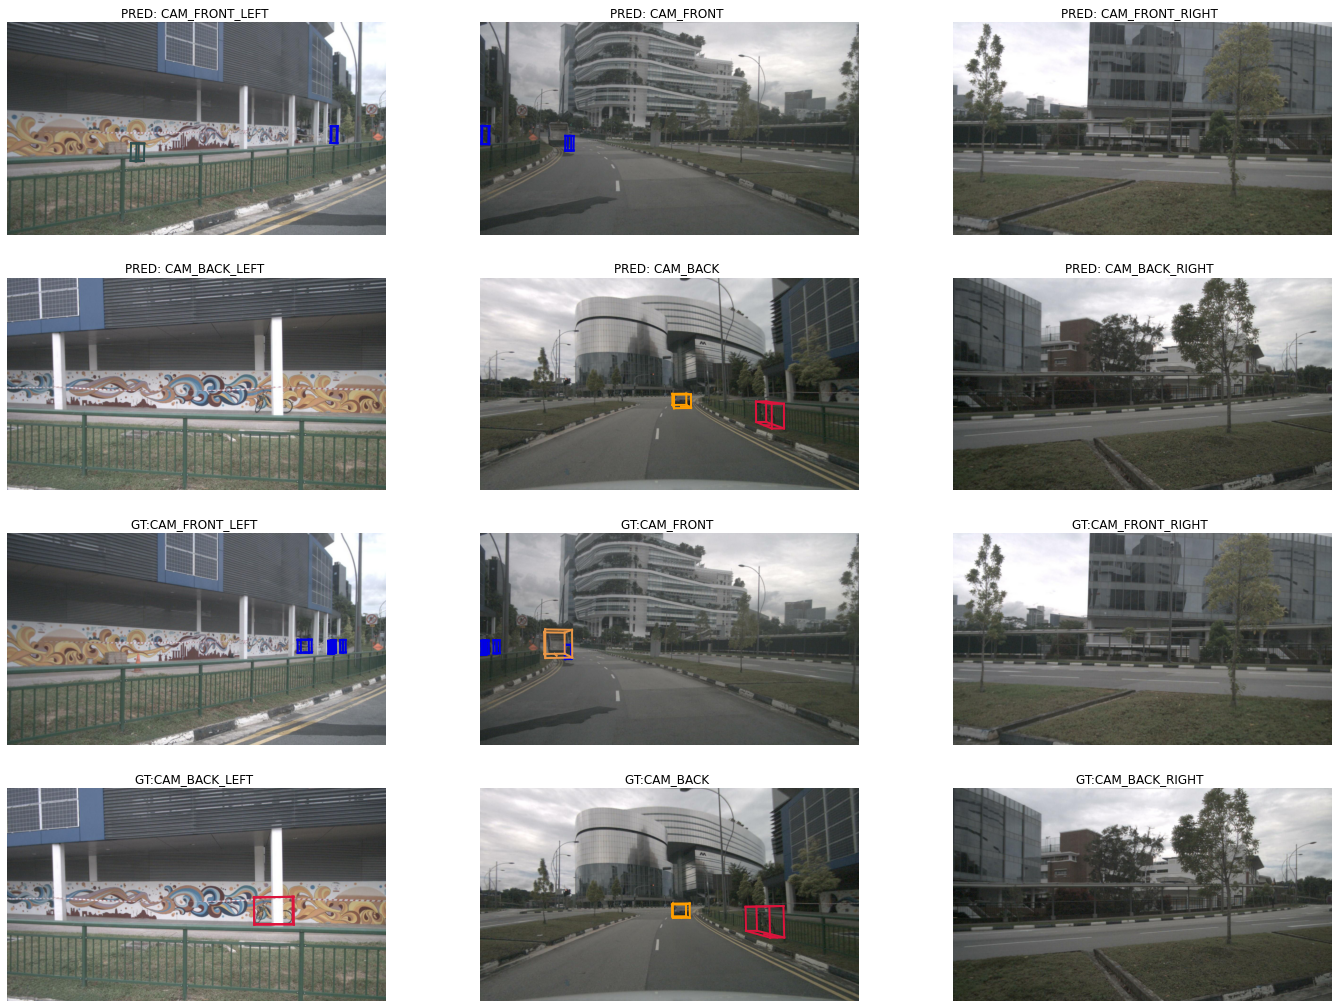

In [9]:
id = 0
render_sample_data(sample_token_list[id], pred_data=bevformer_results, out_path=sample_token_list[id])